In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import STL10
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm.notebook import tqdm
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr_metric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


In [2]:
#  Global Feature Extractor (Frozen ResNet18)
class GlobalFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # Remove the fully connected layer and average pooling layer
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Freeze the weights
        for param in self.features.parameters():
            param.requires_grad = False

        # Preprocessing for ResNet18 (expects 3-channel images)
        self.preprocess_resnet = T.Compose([
            T.Resize((224, 224), antialias=True),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def forward(self, gray_image_bhw1_norm):
        # gray_image_bhw1_norm: [B, 1, H, W], normalized to [0,1]
        # Convert to 3-channel for ResNet by repeating the gray channel
        rgb_like_image = gray_image_bhw1_norm.repeat(1, 3, 1, 1) # [B, 3, H, W]
        processed_image = self.preprocess_resnet(rgb_like_image) # Preprocessed for ResNet

        self.features.eval() # Ensure batch norm and dropout are in eval mode
        with torch.no_grad(): # Ensure no gradients for frozen part
            feature_map = self.features(processed_image) # [B, 512, H'/32, W'/32]

        h_global = self.pool(feature_map) # [B, 512, 1, 1]

        return h_global.squeeze(dim=(2,3)) # [B, 512]

In [3]:
#  Rough Color Estimator
class RoughColorEstimator(nn.Module):
    def __init__(self, global_feature_dim=512, hidden_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(global_feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 6) # a_R, a_G, a_B, b_R, b_G, b_B
        )

    def forward(self, h_global, I_gray_norm_bcwh):
        # h_global: [B, global_feature_dim]
        # I_gray_norm_bcwh: [B, 1, H, W], grayscale image normalized to [0,1]
        # Reshape h_global to have a batch dimension if it's missing
        if h_global.dim() == 1:
            h_global = h_global.unsqueeze(0)


        params = self.mlp(h_global) # [B, 6]
        a = params[:, :3].unsqueeze(-1).unsqueeze(-1) # [B, 3, 1, 1] for broadcasting
        b = params[:, 3:].unsqueeze(-1).unsqueeze(-1) # [B, 3, 1, 1] for broadcasting

        I_rough_color_map = torch.clamp(a * I_gray_norm_bcwh + b, 0, 1) # [B, 3, H, W]
        return I_rough_color_map

In [4]:
#  Pixel Colorization (GRU)
class PixelColorizationRNN(nn.Module):
    def __init__(self, rnn_input_dim, rnn_hidden_dim, global_feature_dim):
        super().__init__()
        self.rnn_hidden_dim = rnn_hidden_dim

        self.mlp_initial_state = nn.Linear(global_feature_dim, rnn_hidden_dim)
        self.gru_cell = nn.GRUCell(rnn_input_dim, rnn_hidden_dim)

        self.mlp_output = nn.Sequential(
            nn.Linear(rnn_hidden_dim, rnn_hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(rnn_hidden_dim // 2, 3), # R, G, B
            nn.Sigmoid()
        )

    def forward(self, I_gray_crop_norm, I_rough_color_map_crop_norm, h_global, window_size=5):
        B, _, C_H, C_W = I_gray_crop_norm.shape
        s_t = torch.tanh(self.mlp_initial_state(h_global))
        C_prev_predicted = torch.zeros(B, 3, device=I_gray_crop_norm.device)

        outputs_rgb_pixels = []
        pad_size = window_size // 2
        I_gray_padded = nn.functional.pad(I_gray_crop_norm, (pad_size, pad_size, pad_size, pad_size), mode='reflect')
        I_rough_padded = nn.functional.pad(I_rough_color_map_crop_norm, (pad_size, pad_size, pad_size, pad_size), mode='reflect')

        for r_idx in range(C_H):
            for c_idx in range(C_W):
                P_gray = I_gray_padded[:, :, r_idx : r_idx + window_size, c_idx : c_idx + window_size].reshape(B, -1)
                P_rough_color = I_rough_padded[:, :, r_idx : r_idx + window_size, c_idx : c_idx + window_size].reshape(B, -1)

                x_t = torch.cat([P_gray, P_rough_color, C_prev_predicted], dim=1)
                s_t = self.gru_cell(x_t, s_t)
                RGB_predicted_current = self.mlp_output(s_t)
                outputs_rgb_pixels.append(RGB_predicted_current)
                C_prev_predicted = RGB_predicted_current

        all_predicted_rgbs_flat = torch.stack(outputs_rgb_pixels, dim=1)
        final_output_image = all_predicted_rgbs_flat.view(B, C_H, C_W, 3).permute(0, 3, 1, 2)
        return final_output_image

In [5]:
#  Combined Colorization Model
class ColorizationModel(nn.Module):
    def __init__(self, global_feature_extractor, rough_color_estimator, pixel_colorization_rnn, window_size=5):
        super().__init__()
        self.global_feature_extractor = global_feature_extractor
        self.rough_color_estimator = rough_color_estimator
        self.pixel_colorization_rnn = pixel_colorization_rnn
        self.window_size = window_size

        for param in self.global_feature_extractor.parameters():
            param.requires_grad = False


    def forward(self, I_gray_full_norm, I_gray_to_colorize_norm):
        # I_gray_full_norm: Full grayscale image for GFE context.
        # I_gray_to_colorize_norm: The actual grayscale image/crop to be colorized by RNN.
        self.global_feature_extractor.eval()
        with torch.no_grad():
            h_global = self.global_feature_extractor(I_gray_full_norm)
        # Rough color map for the part we are colorizing
        I_rough_color_map_to_colorize = self.rough_color_estimator(h_global, I_gray_to_colorize_norm)

        predicted_rgb = self.pixel_colorization_rnn(
            I_gray_to_colorize_norm,
            I_rough_color_map_to_colorize,
            h_global,
            window_size=self.window_size
        )
        return predicted_rgb

# --- Model Hyperparameters ---
WINDOW_SIZE = 3
RNN_INPUT_DIM = (WINDOW_SIZE**2 * 1) + (WINDOW_SIZE**2 * 3) + 3
RNN_HIDDEN_DIM = 128
GLOBAL_FEATURE_DIM = 512
ROUGH_COLOR_MLP_HIDDEN_DIM = 64

gfe = GlobalFeatureExtractor().to(device)
rce = RoughColorEstimator(GLOBAL_FEATURE_DIM, ROUGH_COLOR_MLP_HIDDEN_DIM).to(device)
pcr = PixelColorizationRNN(RNN_INPUT_DIM, RNN_HIDDEN_DIM, GLOBAL_FEATURE_DIM).to(device)

model2 = ColorizationModel(gfe, rce, pcr, window_size=WINDOW_SIZE).to(device)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params_model2 = count_trainable_parameters(model2.rough_color_estimator) + \
                          count_trainable_parameters(model2.pixel_colorization_rnn)
print(f"Total trainable params in Model2: {trainable_params_model2:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Total trainable params in Model2: 172,233


In [6]:
#  Dataset and DataLoader

CROP_SIZE = 32

class STL10ColorizationDataset(Dataset):
    def __init__(self, stl10_dataset, crop_size, is_train=True):
        self.stl10_dataset = stl10_dataset
        self.crop_size = crop_size
        self.is_train = is_train

        self.to_tensor = T.ToTensor()
        self.to_grayscale = T.Grayscale(num_output_channels=1)

        if self.is_train:
            self.crop_transform = T.RandomCrop(crop_size)
        else:
            self.crop_transform = T.CenterCrop(crop_size)

    def __len__(self):
        return len(self.stl10_dataset)

    def __getitem__(self, idx):
        original_color_pil, _ = self.stl10_dataset[idx]
        original_color_tensor = self.to_tensor(original_color_pil)
        grayscale_tensor = self.to_grayscale(original_color_tensor)

        stacked_for_crop = torch.cat([grayscale_tensor, original_color_tensor], dim=0)
        cropped_stacked = self.crop_transform(stacked_for_crop)

        grayscale_crop = cropped_stacked[0:1, :, :]
        target_color_crop = cropped_stacked[1:4, :, :]
        full_grayscale_for_gfe = grayscale_tensor

        return full_grayscale_for_gfe, grayscale_crop, target_color_crop

data_path = './data_stl10'
train_stl10_raw = STL10(root=data_path, split='train', download=True)
test_stl10_raw = STL10(root=data_path, split='test', download=True)

train_dataset = STL10ColorizationDataset(train_stl10_raw, crop_size=CROP_SIZE, is_train=True)
val_dataset = STL10ColorizationDataset(test_stl10_raw, crop_size=CROP_SIZE, is_train=False)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"STL-10 train images: {len(train_stl10_raw)}, test images: {len(test_stl10_raw)}")
print(f"Using training crop size: {CROP_SIZE}x{CROP_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

100%|██████████| 2.64G/2.64G [01:12<00:00, 36.4MB/s]


STL-10 train images: 5000, test images: 8000
Using training crop size: 32x32
Batch size: 16


In [7]:
#  Training Loop
trainable_parameters = list(model2.rough_color_estimator.parameters()) + \
                       list(model2.pixel_colorization_rnn.parameters())

optimizer = optim.AdamW(trainable_parameters, lr=2e-4, weight_decay=1e-5)
criterion = nn.HuberLoss()
GRAD_CLIP_VALUE = 1.0

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    model.global_feature_extractor.eval()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for full_gray, gray_crop, target_color_crop in progress_bar:
        full_gray, gray_crop, target_color_crop = \
            full_gray.to(device), gray_crop.to(device), target_color_crop.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
             h_global_batch = model.global_feature_extractor(full_gray)
        rough_color_map_crop = model.rough_color_estimator(h_global_batch, gray_crop)
        predicted_color_crop = model.pixel_colorization_rnn(
            gray_crop, rough_color_map_crop, h_global_batch, window_size=model.window_size
        )

        loss = criterion(predicted_color_crop, target_color_crop)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_parameters, GRAD_CLIP_VALUE)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for full_gray, gray_crop, target_color_crop in progress_bar:
            full_gray, gray_crop, target_color_crop = \
                full_gray.to(device), gray_crop.to(device), target_color_crop.to(device)

            h_global_batch = model.global_feature_extractor(full_gray)
            rough_color_map_crop = model.rough_color_estimator(h_global_batch, gray_crop)
            predicted_color_crop = model.pixel_colorization_rnn(
                gray_crop, rough_color_map_crop, h_global_batch, window_size=model.window_size
            )
            loss = criterion(predicted_color_crop, target_color_crop)
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

NUM_EPOCHS = 10
best_val_loss = float('inf')
model_save_path = 'best_colorization_model_stl10.pth'

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model2, train_loader, optimizer, criterion, device)
    val_loss = validate_epoch(model2, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} => Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': {
                'rough_color_estimator': model2.rough_color_estimator.state_dict(),
                'pixel_colorization_rnn': model2.pixel_colorization_rnn.state_dict(),
            },
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, model_save_path)
        print(f"Saved new best model to {model_save_path} with Val Loss: {best_val_loss:.6f}")

print("Training finished.")
if os.path.exists(model_save_path):
    checkpoint = torch.load(model_save_path, map_location=device)
    model2.rough_color_estimator.load_state_dict(checkpoint['model_state_dict']['rough_color_estimator'])
    model2.pixel_colorization_rnn.load_state_dict(checkpoint['model_state_dict']['pixel_colorization_rnn'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with Val Loss: {checkpoint['loss']:.6f}")
else:
    print("No saved model found. Using the current model state.")

Starting training...


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10 => Train Loss: 0.012251, Val Loss: 0.005125
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.005125


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10 => Train Loss: 0.004548, Val Loss: 0.004411
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.004411


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10 => Train Loss: 0.003783, Val Loss: 0.003885
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.003885


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10 => Train Loss: 0.003452, Val Loss: 0.003605
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.003605


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10 => Train Loss: 0.003183, Val Loss: 0.003381
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.003381


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10 => Train Loss: 0.003089, Val Loss: 0.003379
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.003379


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10 => Train Loss: 0.002904, Val Loss: 0.003283
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.003283


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10 => Train Loss: 0.002904, Val Loss: 0.003226
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.003226


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10 => Train Loss: 0.002875, Val Loss: 0.003265


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10 => Train Loss: 0.002852, Val Loss: 0.003180
Saved new best model to best_colorization_model_stl10.pth with Val Loss: 0.003180
Training finished.
Loaded best model from epoch 10 with Val Loss: 0.003180


In [8]:
#  Evaluation Metrics

def calculate_psnr_ssim(pred_img_tensor, target_img_tensor, data_range=1.0):
    pred_img_np = pred_img_tensor.detach().cpu().permute(0, 2, 3, 1).numpy()
    target_img_np = target_img_tensor.detach().cpu().permute(0, 2, 3, 1).numpy()

    batch_psnr, batch_ssim = [], []
    for i in range(pred_img_np.shape[0]):
        pred, target = np.clip(pred_img_np[i], 0, 1), np.clip(target_img_np[i], 0, 1)
        # For SSIM, win_size should be odd and <= min(H,W). Default is 7.
        # make win_size adaptive if image dim is too small.
        min_dim = min(pred.shape[0], pred.shape[1])
        current_win_size = min(7, min_dim if min_dim % 2 == 1 else min_dim -1 )
        if current_win_size < 3 : # ssim requires win_size >=3
            current_win_size = 3
            if min_dim < 3: # if image is smaller than 3x3, ssim is not well defined
                ssim_val = 0 # or handle as NaN or skip
            else:
                 ssim_val = ssim_metric(target, pred, data_range=data_range, channel_axis=-1, win_size=current_win_size)
        else:
            ssim_val = ssim_metric(target, pred, data_range=data_range, channel_axis=-1, win_size=current_win_size)

        psnr = psnr_metric(target, pred, data_range=data_range)
        batch_psnr.append(psnr)
        batch_ssim.append(ssim_val)

    return np.mean(batch_psnr), np.mean(batch_ssim)

model2.eval()
all_psnr, all_ssim = [], []
eval_progress_bar = tqdm(val_loader, desc="Metrics Evaluation", leave=False)

with torch.no_grad():
    for full_gray, gray_crop, target_color_crop in eval_progress_bar:
        full_gray, gray_crop, target_color_crop = \
            full_gray.to(device), gray_crop.to(device), target_color_crop.to(device)

        h_global_batch = model2.global_feature_extractor(full_gray)
        rough_color_map_crop = model2.rough_color_estimator(h_global_batch, gray_crop)
        predicted_color_crop = model2.pixel_colorization_rnn(
            gray_crop, rough_color_map_crop, h_global_batch, window_size=model2.window_size
        )

        psnr, ssim_val = calculate_psnr_ssim(predicted_color_crop, target_color_crop)
        all_psnr.append(psnr)
        all_ssim.append(ssim_val)

avg_psnr = np.mean(all_psnr) if all_psnr else 0
avg_ssim = np.mean(all_ssim) if all_ssim else 0
print(f"Average PSNR on Validation Set (Crops): {avg_psnr:.2f} dB")
print(f"Average SSIM on Validation Set (Crops): {avg_ssim:.4f}")

Metrics Evaluation:   0%|          | 0/500 [00:00<?, ?it/s]

Average PSNR on Validation Set (Crops): 24.67 dB
Average SSIM on Validation Set (Crops): 0.9125


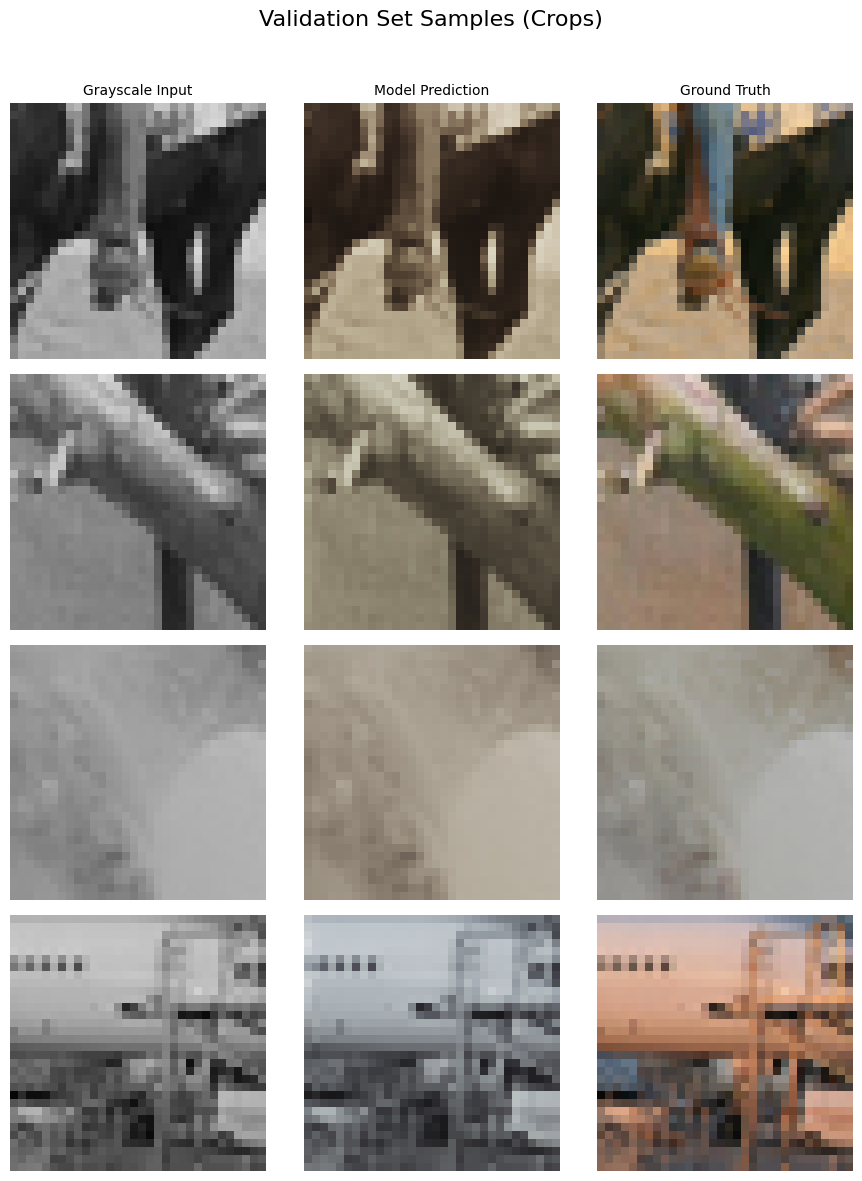

In [9]:
# Visualization Function

def display_colorization_results(gray_inputs_tensor, model_predictions_tensor, ground_truths_tensor,
                                 num_images_to_show=4, super_title="Model Colorization Performance",
                                 class_labels=None,
                                 is_detailed_test_view=False):
    gray_inputs_np = gray_inputs_tensor.cpu().numpy()
    model_predictions_np = model_predictions_tensor.cpu().numpy()
    ground_truths_np = ground_truths_tensor.cpu().numpy()

    num_to_display = min(num_images_to_show, gray_inputs_np.shape[0])
    if num_to_display == 0:
        print("No images to display.")
        return

    fig_width = 12 if is_detailed_test_view else 9 # Wider for longer titles
    fig_height_per_row = 4 if is_detailed_test_view else 3 # Taller for longer titles

    fig, axes = plt.subplots(num_to_display, 3, figsize=(fig_width, fig_height_per_row * num_to_display))
    if num_to_display == 1:
        axes = np.array([axes])

    column_base_titles = ["Grayscale Input", "Model Prediction", "Ground Truth"]

    for i in range(num_to_display):
        row_specific_title_info = ""
        if class_labels and i < len(class_labels) and class_labels[i] is not None:
            row_specific_title_info = class_labels[i]

        for j, ax in enumerate(axes[i]):
            if j == 0: # Grayscale
                img_data = gray_inputs_np[i].squeeze()
                ax.imshow(img_data, cmap='gray', vmin=0, vmax=1)
            elif j == 1: # Model Prediction
                img_data = np.transpose(model_predictions_np[i], (1, 2, 0))
                img_data = np.clip(img_data, 0, 1)
                ax.imshow(img_data, vmin=0, vmax=1)
            else: # Ground Truth
                img_data = np.transpose(ground_truths_np[i], (1, 2, 0))
                img_data = np.clip(img_data, 0, 1)
                ax.imshow(img_data, vmin=0, vmax=1)
            ax.axis('off')
            if i == 0 : # Set column titles only for the first row
                 ax.set_title(column_base_titles[j], fontsize=10)

            if is_detailed_test_view and j == 0:
                ax.set_ylabel(row_specific_title_info, rotation=0, labelpad=40, va='center', ha='right', fontsize=9)


    if super_title:
        fig.suptitle(super_title, fontsize=16)

    # Adjust layout
    if is_detailed_test_view:
        plt.subplots_adjust(left=0.25, top=0.92, hspace=0.3)
    else:
        plt.tight_layout(rect=(0, 0, 1, 0.96) if super_title else None)
    plt.show()

# --- Visualize some results from validation set ---
model2.eval()
with torch.no_grad():
    full_gray_val, gray_crop_val, target_color_crop_val = next(iter(val_loader))
    full_gray_val, gray_crop_val, target_color_crop_val = \
        full_gray_val.to(device), gray_crop_val.to(device), target_color_crop_val.to(device)

    h_global_val = model2.global_feature_extractor(full_gray_val)
    rough_map_crop_val = model2.rough_color_estimator(h_global_val, gray_crop_val)
    predicted_color_crop_val = model2.pixel_colorization_rnn(
        gray_crop_val, rough_map_crop_val, h_global_val, window_size=model2.window_size
    )

    display_colorization_results(gray_crop_val, predicted_color_crop_val, target_color_crop_val,
                                 num_images_to_show=4,
                                 super_title="Validation Set Samples (Crops)",
                                 is_detailed_test_view=False)

  0%|          | 0/8000 [00:00<?, ?it/s]

Preparing Diverse Category Images:   0%|          | 0/10 [00:00<?, ?it/s]


Displaying results for 10 diverse categories from STL-10 Test Set (Full 96x96):


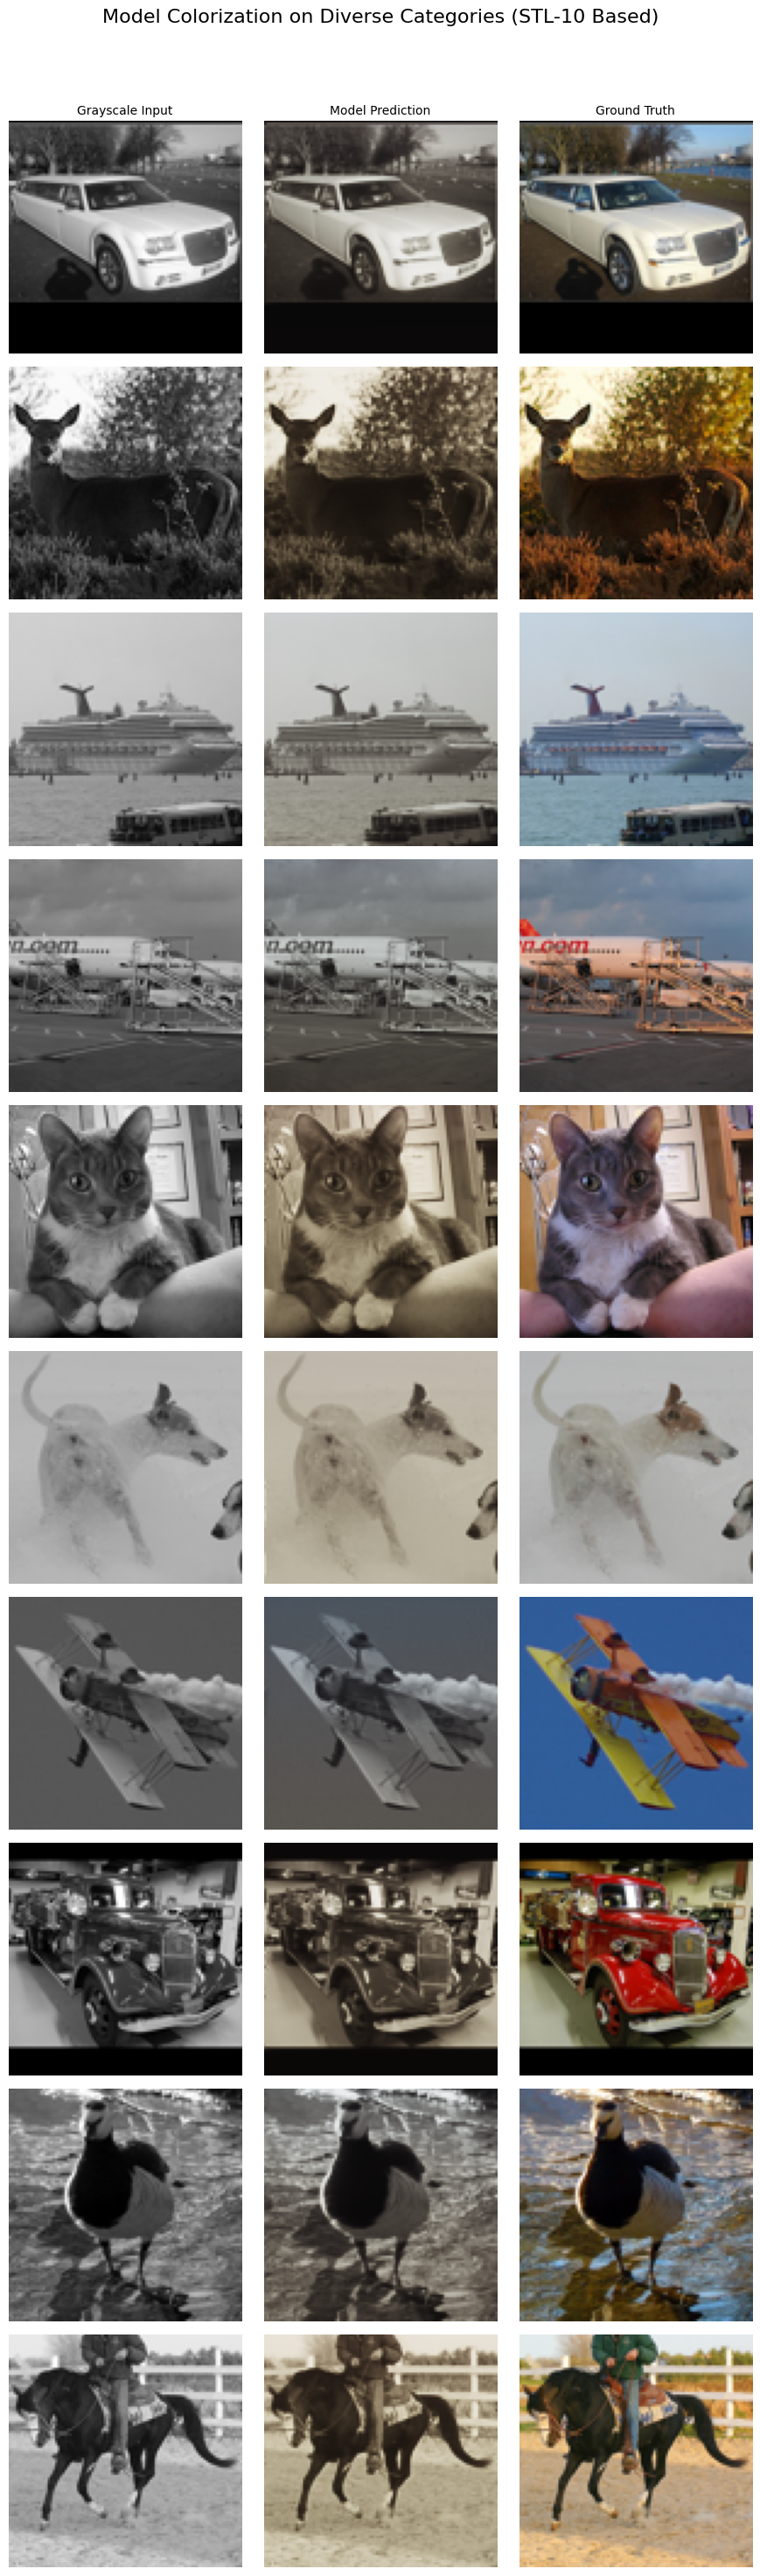

In [10]:
# Testing on 10 Diverse Categories using STL-10 Test Set

if 'stl10_test_for_diversity' not in globals() or 'indices_per_class' not in globals():
    if 'data_path' not in globals():
        data_path = './data_stl10'
        print(f"Warning: 'data_path' not found, using default: {data_path}")

    stl10_test_for_diversity = STL10(root=data_path, split='test', download=True, transform=None)

    indices_per_class = {cls_idx: [] for cls_idx in range(10)}
    for original_idx in tqdm(range(len(stl10_test_for_diversity))):
        _, label_int = stl10_test_for_diversity[original_idx]
        indices_per_class[label_int].append(original_idx)


# STL-10 Class Indices: airplane:0, bird:1, car:2, cat:3, deer:4, dog:5, frog:6, horse:7, ship:8, truck:9
diverse_categories_config = [
    ("Urban/Cityscape (Car)", 2, 0),
    ("Forest/Nature (Deer)", 4, 0),
    ("Beach/Ocean (Ship)", 8, 0),
    ("Mountains/Snow (Airplane Sky)", 0, 0),
    ("Human Portrait (Proxy: Cat)", 3, 0),
    ("Animal (Dog)", 5, 0),
    ("Sky with Clouds (Airplane)", 0, 1),
    ("Indoor Scene (Proxy: Truck)", 9, 0),
    ("Flowers/Garden (Proxy: Bird)", 1, 0),
    ("Food (Proxy: Frog)", 6, 0)
]

selected_gray_images_diverse = []
selected_pred_images_diverse = []
selected_gt_images_diverse = []
selected_plot_labels_diverse = []
if 'model2' not in globals():
    print("Error: 'model2' is not defined. Please ensure the model is loaded.")
else:
    model2.eval()
    with torch.no_grad():
        for display_label, stl10_class_idx, img_idx_in_class_list in tqdm(diverse_categories_config, desc="Preparing Diverse Category Images"):

            if stl10_class_idx not in indices_per_class or not indices_per_class[stl10_class_idx]:
                print(f"Warning: No images found in STL-10 class index {stl10_class_idx} for '{display_label}'. Skipping.")
                continue

            actual_img_idx_in_class_list = min(img_idx_in_class_list, len(indices_per_class[stl10_class_idx]) - 1)
            if actual_img_idx_in_class_list < 0:
                 print(f"Warning: Class index {stl10_class_idx} resulted in invalid image index for '{display_label}'. Skipping.")
                 continue

            image_original_dataset_idx = indices_per_class[stl10_class_idx][actual_img_idx_in_class_list]
            pil_img_color, _ = stl10_test_for_diversity[image_original_dataset_idx]

            full_color_tensor_chw = T.ToTensor()(pil_img_color)
            full_color_tensor_bchw = full_color_tensor_chw.unsqueeze(0).to(device)
            full_gray_tensor_bchw = T.Grayscale(num_output_channels=1)(full_color_tensor_bchw)

            h_global_full = model2.global_feature_extractor(full_gray_tensor_bchw)
            rough_map_full = model2.rough_color_estimator(h_global_full, full_gray_tensor_bchw)

            predicted_color_full = model2.pixel_colorization_rnn(
                full_gray_tensor_bchw,
                rough_map_full,
                h_global_full,
                window_size=model2.window_size
            )

            selected_gray_images_diverse.append(full_gray_tensor_bchw.cpu())
            selected_pred_images_diverse.append(predicted_color_full.cpu())
            selected_gt_images_diverse.append(full_color_tensor_bchw.cpu())
            selected_plot_labels_diverse.append(display_label)

if selected_gray_images_diverse:
    final_gray_batch_diverse = torch.cat(selected_gray_images_diverse, dim=0)
    final_pred_batch_diverse = torch.cat(selected_pred_images_diverse, dim=0)
    final_gt_batch_diverse = torch.cat(selected_gt_images_diverse, dim=0)

    print("\nDisplaying results for 10 diverse categories from STL-10 Test Set (Full 96x96):")
    # Ensure 'display_colorization_results' and 'device' are defined
    if 'display_colorization_results' not in globals():
        print("Error: 'display_colorization_results' function is not defined.")
    elif 'device' not in globals():
        print("Error: 'device' is not defined.")
    else:
        display_colorization_results(
            final_gray_batch_diverse,
            final_pred_batch_diverse,
            final_gt_batch_diverse,
            num_images_to_show=len(selected_gray_images_diverse),
            super_title="Model Colorization on Diverse Categories (STL-10 Based)",
            class_labels=selected_plot_labels_diverse
        )
else:
    if 'model2' in globals():
        print("No diverse category images were processed from STL-10 test set based on the configuration.")

# --- Analysis of Model 2 ---


Model is not learning much, as shown by training/validation losses and a decent SSIM of 0.91, meaning it keeps image structures.
However, the main issue is very poor color quality. Predictions are extremely desaturated and brownish, lacking vibrancy (PSNR result is mediocre). It seems to predict "average" safe colors rather than bold, correct ones, likely due to the MSE loss and the RNN struggling with complex color decisions from local context.